In [1]:
import numpy as np
import pandas as pd
import torch
import pickle
import matplotlib.pyplot as plt
from lpne.models import DcsfaNmf

MODEL_FILE = "/hpc/home/mk423/Anxiety/FullDataWork/Models/Final_mt_Model_500_epochs.pt"
DATA_PATH = "/work/mk423/Anxiety/"
PROJECT_PATH = "/hpc/home/mk423/Anxiety/FullDataWork/Projections/"
FIGURE_PATH = "/hpc/home/mk423/Anxiety/FullDataWork/Figures/"
oft_proj_file = PROJECT_PATH + "OFT_Holdout_Projections.csv"
oft_mean_file = PROJECT_PATH + "OFT_Holdout_mean_scores.csv"
flx_proj_file = PROJECT_PATH + "FLX_Holdout_Projections.csv"
flx_mean_file = PROJECT_PATH + "FLX_Holdout_mean_scores.csv"
epm_proj_file = PROJECT_PATH + "EPM_Holdout_Projections.csv"
epm_mean_file = PROJECT_PATH + "EPM_Holdout_mean_scores.csv"

model = torch.load(MODEL_FILE,map_location="cpu")
model.device="cpu"


old_feature_list = ["X_power_1_2","X_coh_1_2","X_gc_1_2"]

feature_list = ["X_psd","X_coh","X_gc"]
feature_weights = [10,1,1]

feature_weights = [10,1,1]

import os, sys
umc_data_tools_path = "/hpc/home/mk423/Anxiety/Universal-Mouse-Code/"
sys.path.append(umc_data_tools_path)
import umc_data_tools as umc_dt

/opt/conda/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/hpc/home/mk423/.local/lib/python3.7/site-packages/lpne/pipelines/__init__.py:14: UserWarning: Could not load lpne/pipelines/default_params.yaml!
  warnings.warn("Could not load lpne/pipelines/default_params.yaml!")


In [2]:
flx_df = pd.read_csv(flx_proj_file)
epm_df = pd.read_csv(epm_proj_file)
oft_df = pd.read_csv(oft_proj_file)

In [39]:
for mouse in np.unique(epm_df.mouse):
    mouse_mask = np.array(epm_df.mouse).astype(str)==mouse
    task_mask = np.array(epm_df["in-task"]==1)
    mask = np.logical_and(mouse_mask,task_mask)

    print(mouse,(np.max(epm_df[mask==1].time) - np.min(epm_df[mask==1].time)) / 60)

Mouse0641 10.133333333333333
Mouse39115 5.716666666666667
Mouse39121 6.433333333333334
Mouse39122 5.45
Mouse39132 5.85
Mouse39135 5.883333333333334
Mouse6674 10.383333333333333
Mouse69061 6.266666666666667
Mouse69071 6.45
Mouse69075 6.116666666666666
Mouse8893 10.383333333333333


array(['Mouse0641', 'Mouse39115', 'Mouse39121', 'Mouse39122',
       'Mouse39132', 'Mouse39135', 'Mouse6674', 'Mouse69061',
       'Mouse69071', 'Mouse69075', 'Mouse8893'], dtype=object)

## Check Net 1 and Net 2 Correlations EPM

In [3]:
epm_df.head()

,Unnamed: 0,net 1 scores,net 2 scores,net 3 scores,in-task,mouse,time,expDate,auc (Homecage vs. Task),net 1 auc (Homecage vs. Task),net 2 auc (Homecage vs. Task),net 3 auc (Homecage vs. Task),roi,velocity
0,0,0.081440,0.092658,0.096652,False,Mouse0641,1,110717,0.742232,0.71893,0.735664,0.442271,1,-2147483648
1,1,0.062944,0.062938,0.081924,False,Mouse0641,2,110717,0.742232,0.71893,0.735664,0.442271,1,-2147483648
2,2,0.083994,0.098514,0.112678,False,Mouse0641,4,110717,0.742232,0.71893,0.735664,0.442271,3,-2147483648
3,3,0.129436,0.163424,0.065320,False,Mouse0641,12,110717,0.742232,0.71893,0.735664,0.442271,3,-2147483648
4,4,0.072507,0.120995,0.040223,False,Mouse0641,13,110717,0.742232,0.71893,0.735664,0.442271,3,-2147483648


In [4]:
from scipy.stats import spearmanr

task_mask = epm_df["in-task"]==1
unshift_list = []
n1s_lag_list = []
n2s_lag_list = []
for mouse in np.unique(epm_df.mouse):
    mouse_mask = epm_df.mouse==mouse
    mask = np.logical_and(task_mask,mouse_mask)
    
    n1s = epm_df[mask==1]["net 1 scores"]
    n2s = epm_df[mask==1]["net 2 scores"]
    
    unshift = spearmanr(n1s,n2s)[0]**2
    shift_n1s = spearmanr(n1s[1:],n2s[:-1])[0]**2
    shift_n2s = spearmanr(n1s[:-1],n2s[1:])[0]**2
    print("{}, Unshifted R2: {:.2f}, Net 1 lags: {:.2f}, Net 2 lags {:.2f}".format(mouse,unshift,shift_n1s,shift_n2s))
    
    unshift_list.append(unshift)
    n1s_lag_list.append(shift_n1s)
    n2s_lag_list.append(shift_n2s)
    
mean_unshift = np.mean(unshift_list)
sterr_unshift = np.std(unshift_list) / np.sqrt(len(unshift_list))

mean_n1_lag = np.mean(n1s_lag_list)
sterr_n1_lag = np.std(n1s_lag_list) / np.sqrt(len(n1s_lag_list))

mean_n2_lag = np.mean(n2s_lag_list)
sterr_n2_lag = np.std(n2s_lag_list) / np.sqrt(len(n2s_lag_list))

print("\nin EPM R^2 between net 1 and 2, Unshift: {:.2f} +/- {:.2f}, n1 lags: {:.2f} +/- {:.2f}, n2 lags: {:.2f} +/- {:.2f}".format(mean_unshift,sterr_unshift,mean_n1_lag,sterr_n1_lag,mean_n2_lag,sterr_n2_lag))

Mouse0641, Unshifted R2: 0.39, Net 1 lags: 0.01, Net 2 lags 0.02
Mouse39115, Unshifted R2: 0.49, Net 1 lags: 0.05, Net 2 lags 0.01
Mouse39121, Unshifted R2: 0.55, Net 1 lags: 0.03, Net 2 lags 0.01
Mouse39122, Unshifted R2: 0.28, Net 1 lags: 0.00, Net 2 lags 0.00
Mouse39132, Unshifted R2: 0.42, Net 1 lags: 0.00, Net 2 lags 0.02
Mouse39135, Unshifted R2: 0.41, Net 1 lags: 0.02, Net 2 lags 0.01
Mouse6674, Unshifted R2: 0.32, Net 1 lags: 0.01, Net 2 lags 0.01
Mouse69061, Unshifted R2: 0.55, Net 1 lags: 0.02, Net 2 lags 0.02
Mouse69071, Unshifted R2: 0.54, Net 1 lags: 0.00, Net 2 lags 0.00
Mouse69075, Unshifted R2: 0.45, Net 1 lags: 0.02, Net 2 lags 0.04
Mouse8893, Unshifted R2: 0.51, Net 1 lags: 0.01, Net 2 lags 0.01

in EPM R^2 between net 1 and 2, Unshift: 0.45 +/- 0.03, n1 lags: 0.01 +/- 0.00, n2 lags: 0.01 +/- 0.00


## Check Net 1 and 2 in FLX

In [5]:
flx_df.head()

,Unnamed: 0,comp score,net 1 scores,net 2 scores,net 3 scores,flx,mouse,time,expDate,auc (last-30-minutes),net 1 auc (last-30-minutes),net 2 auc (last-30-minutes),net 3 auc (last-30-minutes),by-minute auc (last-30-minutes),by-minute net 1 auc (last-30-minutes),by-minute net 2 auc (last-30-minutes),by-minute net 3 auc (last-30-minutes)
0,0,3.266297,0.095238,0.137678,0.052358,1.0,Mouse78732,1,40623,0.606754,0.531262,0.619474,0.45065,0.937304,0.641588,0.935214,0.248694
1,1,4.073864,0.111536,0.174981,0.088253,1.0,Mouse78732,2,40623,0.606754,0.531262,0.619474,0.45065,0.937304,0.641588,0.935214,0.248694
2,2,3.786834,0.104888,0.164768,0.016867,1.0,Mouse78732,3,40623,0.606754,0.531262,0.619474,0.45065,0.937304,0.641588,0.935214,0.248694
3,3,4.066449,0.103743,0.182411,0.012262,1.0,Mouse78732,4,40623,0.606754,0.531262,0.619474,0.45065,0.937304,0.641588,0.935214,0.248694
4,4,4.709885,0.103712,0.220500,0.024219,1.0,Mouse78732,6,40623,0.606754,0.531262,0.619474,0.45065,0.937304,0.641588,0.935214,0.248694


In [6]:
from scipy.stats import spearmanr

task_mask = flx_df["flx"]==1
unshift_list = []
n1s_lag_list = []
n2s_lag_list = []
for mouse in np.unique(flx_df.mouse):
    mouse_mask = flx_df.mouse==mouse
    time_mask = flx_df.time > 60*30
    mask = np.logical_and(task_mask,mouse_mask)
    mask = np.logical_and(mask,time_mask)
    
    n1s = flx_df[mask==1]["net 1 scores"]
    n2s = flx_df[mask==1]["net 2 scores"]
    
    unshift = spearmanr(n1s,n2s)[0]**2
    shift_n1s = spearmanr(n1s[1:],n2s[:-1])[0]**2
    shift_n2s = spearmanr(n1s[:-1],n2s[1:])[0]**2
    print("{}, Unshifted R2: {:.2f}, Net 1 lags: {:.2f}, Net 2 lags {:.2f}".format(mouse,unshift,shift_n1s,shift_n2s))
    
    unshift_list.append(unshift)
    n1s_lag_list.append(shift_n1s)
    n2s_lag_list.append(shift_n2s)
    
mean_unshift = np.mean(unshift_list)
sterr_unshift = np.std(unshift_list) / np.sqrt(len(unshift_list))

mean_n1_lag = np.mean(n1s_lag_list)
sterr_n1_lag = np.std(n1s_lag_list) / np.sqrt(len(n1s_lag_list))

mean_n2_lag = np.mean(n2s_lag_list)
sterr_n2_lag = np.std(n2s_lag_list) / np.sqrt(len(n2s_lag_list))

print("\nLast 30 minutes Received FLX R^2 between net 1 and 2, Unshift: {:.2f} +/- {:.2f}, n1 lags: {:.2f} +/- {:.2f}, n2 lags: {:.2f} +/- {:.2f}".format(mean_unshift,sterr_unshift,mean_n1_lag,sterr_n1_lag,mean_n2_lag,sterr_n2_lag))

Mouse69061, Unshifted R2: 0.45, Net 1 lags: 0.01, Net 2 lags 0.01
Mouse78732, Unshifted R2: 0.21, Net 1 lags: 0.00, Net 2 lags 0.00
Mouse78743, Unshifted R2: 0.22, Net 1 lags: 0.00, Net 2 lags 0.00
Mouse78745, Unshifted R2: 0.28, Net 1 lags: 0.00, Net 2 lags 0.00
Mouse78751, Unshifted R2: 0.25, Net 1 lags: 0.00, Net 2 lags 0.00
Mouse78764, Unshifted R2: 0.20, Net 1 lags: 0.00, Net 2 lags 0.00

Last 30 minutes Received FLX R^2 between net 1 and 2, Unshift: 0.27 +/- 0.04, n1 lags: 0.00 +/- 0.00, n2 lags: 0.00 +/- 0.00


In [7]:
net_1_aucs = []
net_2_aucs = []
net_3_aucs = []
mouse_list = []
experiment = []

for mouse in np.unique(flx_df.mouse):
    
    net_1_aucs.append(flx_df[flx_df.mouse==mouse]["net 1 auc (last-30-minutes)"].values[0])
    net_2_aucs.append(flx_df[flx_df.mouse==mouse]["net 2 auc (last-30-minutes)"].values[0])
    net_3_aucs.append(flx_df[flx_df.mouse==mouse]["net 3 auc (last-30-minutes)"].values[0])
    experiment.append("flx")
    mouse_list.append(mouse)
    
for mouse in np.unique(epm_df.mouse):
    
    net_1_aucs.append(epm_df[epm_df.mouse==mouse]["net 1 auc (Homecage vs. Task)"].values[0])
    net_2_aucs.append(epm_df[epm_df.mouse==mouse]["net 2 auc (Homecage vs. Task)"].values[0])
    net_3_aucs.append(epm_df[epm_df.mouse==mouse]["net 3 auc (Homecage vs. Task)"].values[0])
    experiment.append("epm")
    mouse_list.append(mouse)
    
for mouse in np.unique(oft_df.mouse):
    
    net_1_aucs.append(oft_df[oft_df.mouse==mouse]["net 1 auc (Homecage vs. Task)"].values[0])
    net_2_aucs.append(oft_df[oft_df.mouse==mouse]["net 2 auc (Homecage vs. Task)"].values[0])
    net_3_aucs.append(oft_df[oft_df.mouse==mouse]["net 3 auc (Homecage vs. Task)"].values[0])
    experiment.append("oft")
    mouse_list.append(mouse)
    

by_net_auc_dict = {
    "net_1_auc":net_1_aucs,
    "net_2_auc":net_2_aucs,
    "net_3_auc":net_3_aucs,
    "mouse":mouse_list,
    "experiment":experiment
}

by_net_auc_df = pd.DataFrame.from_dict(by_net_auc_dict)
by_net_auc_df.to_csv(PROJECT_PATH + "MT_by_net_aucs.csv")

In [8]:
by_net_auc_df.head()

,net_1_auc,net_2_auc,net_3_auc,mouse,experiment
0,0.455167,0.405810,0.452284,Mouse69061,flx
1,0.531262,0.619474,0.450650,Mouse78732,flx
2,0.657721,0.656955,0.460283,Mouse78743,flx
3,0.644440,0.614746,0.413110,Mouse78745,flx
4,0.543924,0.559630,0.465508,Mouse78751,flx


In [9]:
num_flx_mice = np.sum(by_net_auc_df.
barWidth = 0.15
fig = plt.subplots(figsize=(24,6))

br1 = np.arange(3)
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]

# Make the plot
plt.bar(br1, flx_mean_list,yerr=flx_sterr_list, width = barWidth,
        edgecolor ='grey', label ='flx',alpha=0.5)
plt.bar(br2, epm_mean_list,yerr=epm_sterr_list, width = barWidth,
        edgecolor ='grey', label ='epm',alpha=0.5)
plt.bar(br3, oft_mean_list,yerr=oft_sterr_list, width = barWidth,
        edgecolor ='grey', label ='oft',alpha=0.5)

for i in range(3):
    plt.scatter(np.ones(len(flx_points_list[i]))*br1[i],flx_points_list[i],color="black")
    plt.scatter(np.ones(len(epm_points_list[i]))*br2[i],epm_points_list[i],color="black")
    plt.scatter(np.ones(len(oft_points_list[i]))*br3[i],oft_points_list[i],color="black")

plt.xticks([r + barWidth for r in range(len(flx_mean_list))],
        [1,2,3])
plt.axhline(0.5,-1,6,linestyle="dashed",color="grey")
plt.xlabel('Network', fontsize = 10)
plt.ylabel('Mean Mann-Whitney AUC', fontsize = 10)
plt.legend()
plt.title("Individual Network Mann-Whitney AUC")
#plt.savefig(plots_path + "individualNetworkAUCs.svg")
plt.show()

SyntaxError: invalid syntax (1847297090.py, line 3)

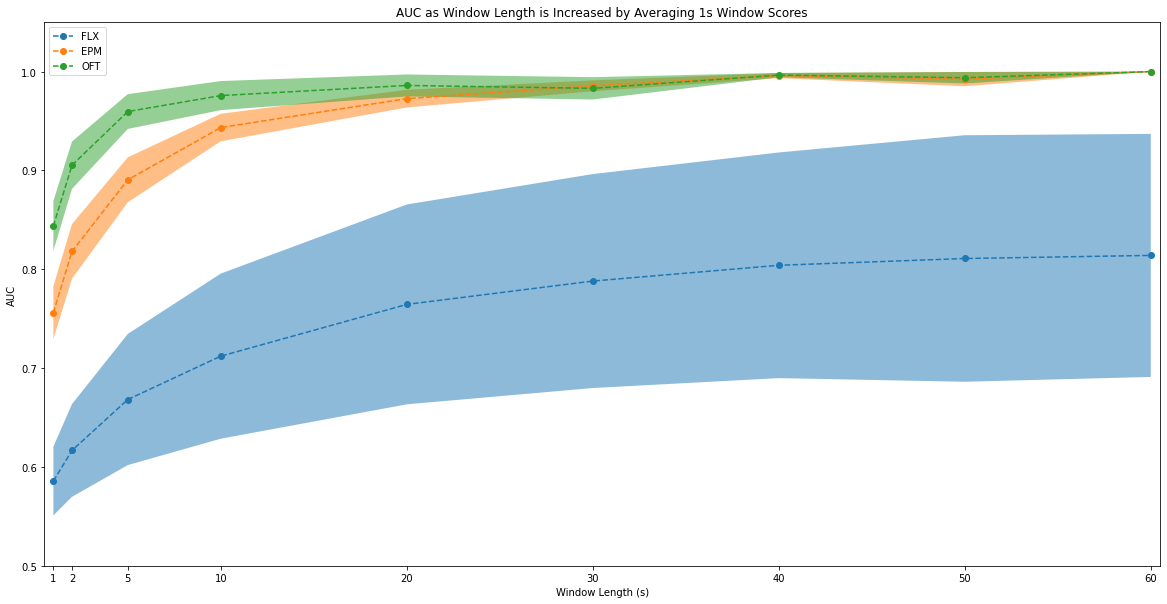

In [11]:
flx_duration_mean = []
flx_duration_std = []

epm_duration_mean = []
epm_duration_std = []

oft_duration_mean = []
oft_duration_std = []
durations = [1,2,5,10,20,30,40,50,60]
for duration in durations:
    
    s_flx = flx_df["comp score"].values
    y_flx = flx_df["flx"].values
    mouse_flx = flx_df["mouse"]
    
    flx_min_mouse = []
    flx_mouse_auc = []
    for mouse in np.unique(mouse_flx):
        mouse_mask = mouse_flx == mouse
        time_mask = flx_df['time'].values > 30*60
        mouse_mask = np.logical_and(mouse_mask,time_mask)
        
        temp_s = s_flx[mouse_mask==1]
        temp_y = y_flx[mouse_mask==1]
        
        if temp_s.shape[0]%duration > 0:
            temp_s = temp_s[:-int(temp_s.shape[0]%duration)].reshape(-1,duration)
            temp_y = temp_y[:-int(temp_y.shape[0]%duration)].reshape(-1,duration)
        else:
            temp_s = temp_s.reshape(-1,duration)
            temp_y = temp_y.reshape(-1,duration)
            
        temp_s = np.mean(temp_s,axis=1)
        temp_y = np.mean(temp_y,axis=1) > 0.5
        auc, pval = model.mw_auc(temp_s,temp_y)
        
        flx_mouse_auc.append(auc)
        flx_min_mouse.append(mouse)
        
    flx_duration_mean.append(np.mean(flx_mouse_auc))
    flx_duration_std.append(np.std(flx_mouse_auc)/np.sqrt(len(flx_mouse_auc)))
        
    
    s_epm = np.hstack((epm_df["net 1 scores"].values.reshape(-1,1),epm_df["net 2 scores"].values.reshape(-1,1),epm_df["net 3 scores"].values.reshape(-1,1))) @ model.classifier[0].weight[0].detach().cpu().numpy()
    y_epm = epm_df["in-task"].values
    mouse_epm = epm_df["mouse"]
    
    epm_mouse_auc = []
    epm_min_mouse = []
    for mouse in np.unique(mouse_epm):
        mouse_mask = mouse_epm == mouse
        temp_s = s_epm[mouse_mask==1]
        temp_y = y_epm[mouse_mask==1]
        
        if temp_s.shape[0]%duration > 0:
            temp_s = temp_s[:-int(temp_s.shape[0]%duration)].reshape(-1,duration)
            temp_y = temp_y[:-int(temp_y.shape[0]%duration)].reshape(-1,duration)
        else:
            temp_s = temp_s.reshape(-1,duration)
            temp_y = temp_y.reshape(-1,duration)
            
        temp_s = np.mean(temp_s,axis=1)
        temp_y = np.mean(temp_y,axis=1) > 0.5
        auc, pval = model.mw_auc(temp_s,temp_y)
        
        epm_mouse_auc.append(auc)
        epm_min_mouse.append(mouse)

    epm_duration_mean.append(np.mean(epm_mouse_auc))
    epm_duration_std.append(np.std(epm_mouse_auc)/np.sqrt(len(epm_mouse_auc)))
    
    s_oft = np.hstack((oft_df["net 1 scores"].values.reshape(-1,1),oft_df["net 2 scores"].values.reshape(-1,1),oft_df["net 3 scores"].values.reshape(-1,1))) @ model.classifier[0].weight[0].detach().cpu().numpy()
    y_oft = oft_df["in-task"].values
    mouse_oft = oft_df["mouse"]
    
    oft_mouse_auc = []
    oft_min_mouse = []
    for mouse in np.unique(mouse_oft):
        mouse_mask = mouse_oft == mouse
        temp_s = s_oft[mouse_mask==1]
        temp_y = y_oft[mouse_mask==1]
        
        if temp_s.shape[0]%duration > 0:
            temp_s = temp_s[:-int(temp_s.shape[0]%duration)].reshape(-1,duration)
            temp_y = temp_y[:-int(temp_y.shape[0]%duration)].reshape(-1,duration)
        else:
            temp_s = temp_s.reshape(-1,duration)
            temp_y = temp_y.reshape(-1,duration)
            
        temp_s = np.mean(temp_s,axis=1)
        temp_y = np.mean(temp_y,axis=1) > 0.5
        auc, pval = model.mw_auc(temp_s,temp_y)
        
        oft_mouse_auc.append(auc)
        oft_min_mouse.append(mouse)

    oft_duration_mean.append(np.mean(oft_mouse_auc))
    oft_duration_std.append(np.std(oft_mouse_auc)/np.sqrt(len(oft_mouse_auc)))
    
flx_duration_mean = np.array(flx_duration_mean)
flx_duration_std = np.array(flx_duration_std)

epm_duration_mean = np.array(epm_duration_mean)
epm_duration_std = np.array(epm_duration_std)

oft_duration_mean = np.array(oft_duration_mean)
oft_duration_std = np.array(oft_duration_std)

plt.figure(figsize=(20,10))
plt.plot(durations,flx_duration_mean,"--o",label="FLX")
plt.fill_between(durations, flx_duration_mean + flx_duration_std, flx_duration_mean - flx_duration_std,alpha=0.5)

plt.plot(durations,epm_duration_mean,"--o",label="EPM")
plt.fill_between(durations, epm_duration_mean + epm_duration_std, epm_duration_mean - epm_duration_std,alpha=0.5)

plt.plot(durations,oft_duration_mean,"--o",label="OFT")
plt.fill_between(durations, oft_duration_mean + oft_duration_std, oft_duration_mean - oft_duration_std,alpha=0.5)

plt.xticks(durations,durations)
plt.ylabel("AUC")
plt.xlabel("Window Length (s)")
plt.legend(loc="upper left")
plt.title("AUC as Window Length is Increased by Averaging 1s Window Scores")
plt.ylim([0.5,1.05])
plt.xlim([0.5,60.5])
#plt.savefig(FIGURE_PATH + "AUC_as_n_windows_is_increased.svg")
plt.show()

In [15]:
flx_df.head()

,Unnamed: 0,comp score,net 1 scores,net 2 scores,net 3 scores,flx,mouse,time,expDate,auc (last-30-minutes),net 1 auc (last-30-minutes),net 2 auc (last-30-minutes),net 3 auc (last-30-minutes),by-minute auc (last-30-minutes),by-minute net 1 auc (last-30-minutes),by-minute net 2 auc (last-30-minutes),by-minute net 3 auc (last-30-minutes)
0,0,3.266297,0.095238,0.137678,0.052358,1.0,Mouse78732,1,40623,0.606754,0.531262,0.619474,0.45065,0.937304,0.641588,0.935214,0.248694
1,1,4.073864,0.111536,0.174981,0.088253,1.0,Mouse78732,2,40623,0.606754,0.531262,0.619474,0.45065,0.937304,0.641588,0.935214,0.248694
2,2,3.786834,0.104888,0.164768,0.016867,1.0,Mouse78732,3,40623,0.606754,0.531262,0.619474,0.45065,0.937304,0.641588,0.935214,0.248694
3,3,4.066449,0.103743,0.182411,0.012262,1.0,Mouse78732,4,40623,0.606754,0.531262,0.619474,0.45065,0.937304,0.641588,0.935214,0.248694
4,4,4.709885,0.103712,0.220500,0.024219,1.0,Mouse78732,6,40623,0.606754,0.531262,0.619474,0.45065,0.937304,0.641588,0.935214,0.248694


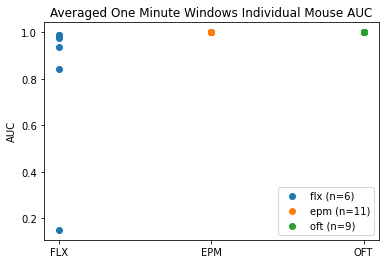

In [11]:

xa = np.zeros(len(flx_mouse_auc))
xb = np.ones(len(epm_mouse_auc))
xc = np.ones(len(oft_mouse_auc))*2

ya = flx_mouse_auc
yb = epm_mouse_auc
yc = oft_mouse_auc

plt.scatter(xa,ya,label="flx (n={})".format(len(flx_mouse_auc)))
plt.scatter(xb,yb,label="epm (n={})".format(len(epm_mouse_auc)))
plt.scatter(xc,yc,label="oft (n={})".format(len(oft_mouse_auc)))

plt.ylabel("AUC")
plt.legend()
plt.xticks(range(3),["FLX","EPM","OFT"])
plt.title("Averaged One Minute Windows Individual Mouse AUC")
#plt.savefig(FIGURE_PATH + "One_Minute_MultiTask_Holdout_AUCs.svg")
plt.show()

In [35]:
df_minute_aucs = {
    "second_flx_auc":[np.unique(flx_df[np.array(flx_df.mouse).astype(str)==flx_min_mouse[i]]["auc (last-30-minutes)"])[0] if i < len(flx_mouse_auc) else np.nan for i in range(len(epm_mouse_auc))],
    "minute_flx_auc":[flx_mouse_auc[i] if i < len(flx_mouse_auc) else np.nan for i in range(len(epm_mouse_auc))],
    "minute_flx_mouse":[flx_min_mouse[i] if i < len(flx_mouse_auc) else np.nan for i in range(len(epm_mouse_auc))],
    
    "second_epm_auc":[np.unique(epm_df[np.array(epm_df.mouse).astype(str)==epm_min_mouse[i]]["auc (Homecage vs. Task)"])[0] if i < len(epm_mouse_auc) else np.nan for i in range(len(epm_mouse_auc))],
    "minute_epm_auc":[epm_mouse_auc[i] if i < len(epm_mouse_auc) else np.nan for i in range(len(epm_mouse_auc))],
    "minute_epm_mouse":[epm_min_mouse[i] if i < len(epm_mouse_auc) else np.nan for i in range(len(epm_mouse_auc))],
    
    "second_oft_auc":[np.unique(oft_df[np.array(oft_df.mouse).astype(str)==oft_min_mouse[i]]["auc (Homecage vs. Task)"])[0] if i < len(oft_mouse_auc) else np.nan for i in range(len(epm_mouse_auc))],
    "minute_oft_auc":[oft_mouse_auc[i] if i < len(oft_mouse_auc) else np.nan for i in range(len(epm_mouse_auc))],
    "minute_oft_mouse":[oft_min_mouse[i] if i < len(oft_mouse_auc) else np.nan for i in range(len(epm_mouse_auc))]
}

df_minute_aucs = pd.DataFrame.from_dict(df_minute_aucs)
df_minute_aucs.to_csv(PROJECT_PATH + "mt_second_and_minute_aucs.csv",index=False)

In [36]:
df_minute_aucs

,second_flx_auc,minute_flx_auc,minute_flx_mouse,second_epm_auc,minute_epm_auc,minute_epm_mouse,second_oft_auc,minute_oft_auc,minute_oft_mouse
0,0.410250,0.150538,Mouse69061,0.742232,1.0,Mouse0641,0.903977,1.0,Mouse04203
1,0.606754,0.937304,Mouse78732,0.891686,1.0,Mouse39115,0.864240,1.0,Mouse39115
2,0.670857,0.989564,Mouse78743,0.906627,1.0,Mouse39121,0.912126,1.0,Mouse39121
3,0.631435,0.977083,Mouse78745,0.719815,1.0,Mouse39122,0.734351,1.0,Mouse39122
4,0.561049,0.840453,Mouse78751,0.663545,1.0,Mouse39132,0.926504,1.0,Mouse39132
5,0.634019,0.989316,Mouse78764,0.871639,1.0,Mouse39135,0.867053,1.0,Mouse39135
6,NaN,NaN,NaN,0.654603,1.0,Mouse6674,0.693549,1.0,Mouse69061
7,NaN,NaN,NaN,0.708518,1.0,Mouse69061,0.826313,1.0,Mouse69071
8,NaN,NaN,NaN,0.738914,1.0,Mouse69071,0.866295,1.0,Mouse69075
9,NaN,NaN,NaN,0.761008,1.0,Mouse69075,NaN,NaN,NaN


In [30]:
epm_df.head()

,Unnamed: 0,net 1 scores,net 2 scores,net 3 scores,in-task,mouse,time,expDate,auc (Homecage vs. Task),net 1 auc (Homecage vs. Task),net 2 auc (Homecage vs. Task),net 3 auc (Homecage vs. Task),roi,velocity
0,0,0.081440,0.092658,0.096652,False,Mouse0641,1,110717,0.742232,0.71893,0.735664,0.442271,1,-2147483648
1,1,0.062944,0.062938,0.081924,False,Mouse0641,2,110717,0.742232,0.71893,0.735664,0.442271,1,-2147483648
2,2,0.083994,0.098514,0.112678,False,Mouse0641,4,110717,0.742232,0.71893,0.735664,0.442271,3,-2147483648
3,3,0.129436,0.163424,0.065320,False,Mouse0641,12,110717,0.742232,0.71893,0.735664,0.442271,3,-2147483648
4,4,0.072507,0.120995,0.040223,False,Mouse0641,13,110717,0.742232,0.71893,0.735664,0.442271,3,-2147483648


In [28]:
flx_df[np.array(flx_df.mouse).astype(str)==flx_min_mouse[0]]

,Unnamed: 0,comp score,net 1 scores,net 2 scores,net 3 scores,flx,mouse,time,expDate,auc (last-30-minutes),net 1 auc (last-30-minutes),net 2 auc (last-30-minutes),net 3 auc (last-30-minutes),by-minute auc (last-30-minutes),by-minute net 1 auc (last-30-minutes),by-minute net 2 auc (last-30-minutes),by-minute net 3 auc (last-30-minutes)
37584,37584,2.688171,0.077362,0.114397,0.031819,1.0,Mouse69061,1,110421,0.41025,0.455167,0.40581,0.452284,0.150538,0.274194,0.148387,0.27957
37585,37585,2.443475,0.061235,0.109378,0.027599,1.0,Mouse69061,2,110421,0.41025,0.455167,0.40581,0.452284,0.150538,0.274194,0.148387,0.27957
37586,37586,2.114253,0.064941,0.088166,0.011245,1.0,Mouse69061,3,110421,0.41025,0.455167,0.40581,0.452284,0.150538,0.274194,0.148387,0.27957
37587,37587,4.097728,0.100593,0.185333,0.030794,1.0,Mouse69061,4,110421,0.41025,0.455167,0.40581,0.452284,0.150538,0.274194,0.148387,0.27957
37588,37588,3.106275,0.084114,0.136270,0.014219,1.0,Mouse69061,5,110421,0.41025,0.455167,0.40581,0.452284,0.150538,0.274194,0.148387,0.27957
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44773,44773,1.573171,0.068693,0.053623,0.008650,0.0,Mouse69061,3767,110521,0.41025,0.455167,0.40581,0.452284,0.150538,0.274194,0.148387,0.27957
44774,44774,2.531873,0.088895,0.098560,0.024643,0.0,Mouse69061,3768,110521,0.41025,0.455167,0.40581,0.452284,0.150538,0.274194,0.148387,0.27957
44775,44775,2.674905,0.071088,0.118150,0.011923,0.0,Mouse69061,3769,110521,0.41025,0.455167,0.40581,0.452284,0.150538,0.274194,0.148387,0.27957
44776,44776,2.859869,0.101545,0.110837,0.023798,0.0,Mouse69061,3770,110521,0.41025,0.455167,0.40581,0.452284,0.150538,0.274194,0.148387,0.27957


In [102]:
flx_mouse_auc

[0.15053763440860216,
 0.9373040752351097,
 0.9895635673624289,
 0.9770833333333333,
 0.8404533565823888,
 0.9893162393162394]

In [45]:
temp_y = y_flx[mouse_mask==1]
temp_y[:-int(temp_y.shape[0]%duration)]

array([], dtype=float64)

In [42]:
temp_y = y_flx[mouse_mask==1]
temp_y = temp_y[:-int(temp_y.shape[0]%duration)].reshape(-1,duration)
temp_y

array([], shape=(0, 1), dtype=float64)

In [8]:
epm_df.head()

,Unnamed: 0,net 1 scores,net 2 scores,net 3 scores,in-task,mouse,time,expDate,auc (Homecage vs. Task),net 1 auc (Homecage vs. Task),net 2 auc (Homecage vs. Task),net 3 auc (Homecage vs. Task),roi,velocity
0,0,0.081440,0.092658,0.096652,False,Mouse0641,1,110717,0.742232,0.71893,0.735664,0.442271,1,-2147483648
1,1,0.062944,0.062938,0.081924,False,Mouse0641,2,110717,0.742232,0.71893,0.735664,0.442271,1,-2147483648
2,2,0.083994,0.098514,0.112678,False,Mouse0641,4,110717,0.742232,0.71893,0.735664,0.442271,3,-2147483648
3,3,0.129436,0.163424,0.065320,False,Mouse0641,12,110717,0.742232,0.71893,0.735664,0.442271,3,-2147483648
4,4,0.072507,0.120995,0.040223,False,Mouse0641,13,110717,0.742232,0.71893,0.735664,0.442271,3,-2147483648


In [9]:
oft_df.head()

,Unnamed: 0,net 1 scores,net 2 scores,net 3 scores,in-task,mouse,time,expDate,auc (Homecage vs. Task),net 1 auc (Homecage vs. Task),net 2 auc (Homecage vs. Task),net 3 auc (Homecage vs. Task),roi,velocity
0,0,0.026420,0.012433,0.007595,False,Mouse04203,1,90421,0.903977,0.895378,0.890808,0.740237,NaN,-2.147484e+09
1,1,0.085713,0.082628,0.027619,False,Mouse04203,3,90421,0.903977,0.895378,0.890808,0.740237,NaN,-2.147484e+09
2,2,0.066529,0.133424,0.023311,False,Mouse04203,4,90421,0.903977,0.895378,0.890808,0.740237,NaN,-2.147484e+09
3,3,0.005939,0.009126,0.056668,False,Mouse04203,5,90421,0.903977,0.895378,0.890808,0.740237,NaN,-2.147484e+09
4,4,0.042559,0.145444,0.015247,False,Mouse04203,6,90421,0.903977,0.895378,0.890808,0.740237,NaN,-2.147484e+09


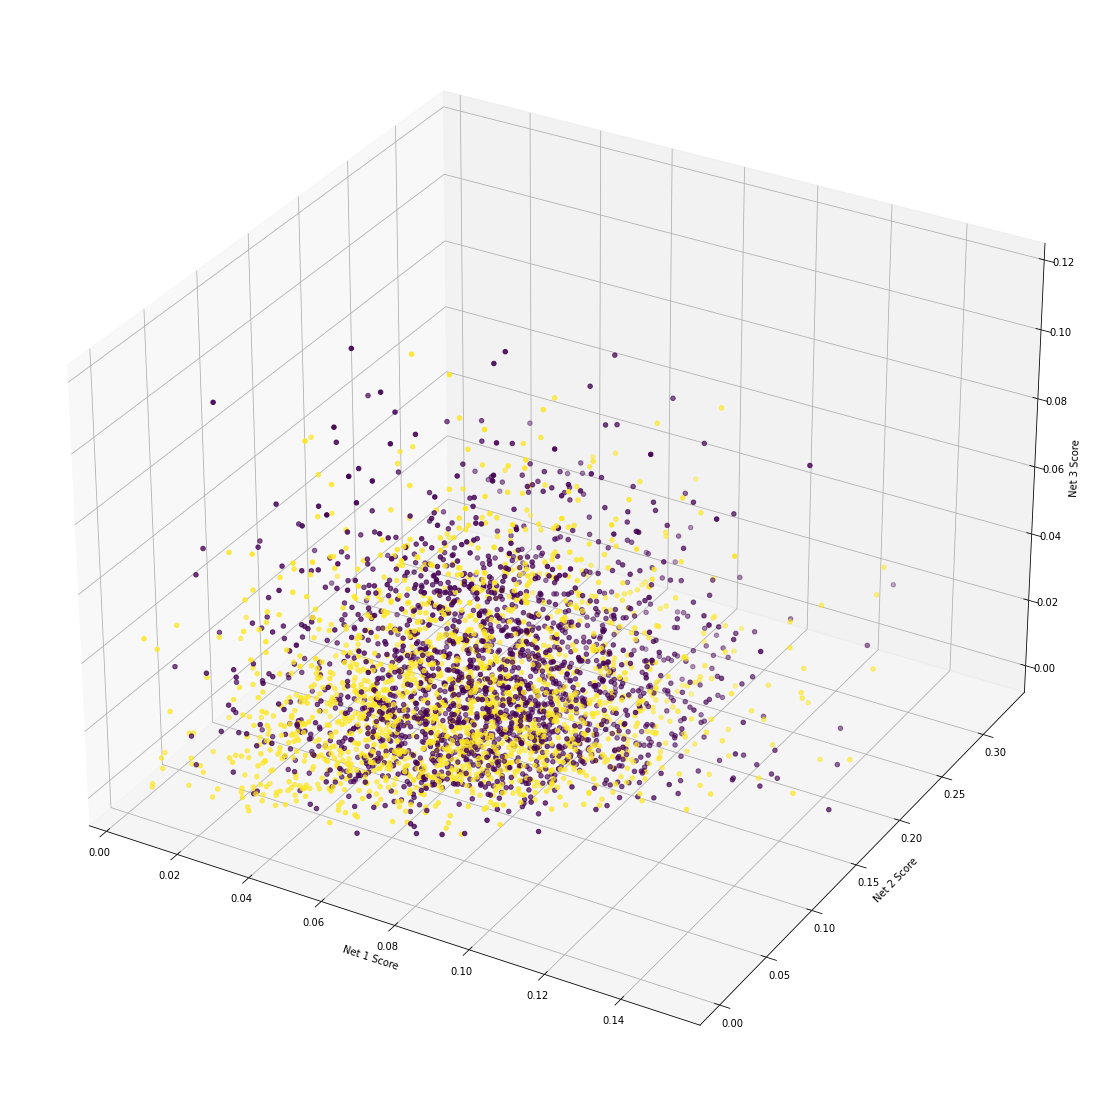

In [ ]:
for mouse in np.unique(flx_df["mouse"]):
    mouse_mask = flx_df["mouse"]==mouse
    time_mask = flx_df["time"] > 60*30
    
    
    mask = np.logical_and(mouse_mask,time_mask)
    
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(projection='3d')
    ax.scatter(flx_df["net 1 scores"][mask==1].values, #/ np.mean(flx_df["net 1 scores"][mask==1]),
               flx_df["net 2 scores"][mask==1].values, #/ np.mean(flx_df["net 2 scores"][mask==1]),
               flx_df["net 3 scores"][mask==1].values, #/ np.mean(flx_df["net 3 scores"][mask==1]),
              c=flx_df['flx'][mask==1])
    ax.set_xlabel('Net 1 Score')
    ax.set_ylabel('Net 2 Score')
    ax.set_zlabel('Net 3 Score')

    plt.show()
    break

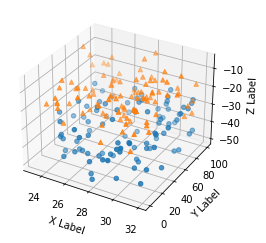

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Fixing random state for reproducibility
np.random.seed(19680801)


def randrange(n, vmin, vmax):
    """
    Helper function to make an array of random numbers having shape (n, )
    with each number distributed Uniform(vmin, vmax).
    """
    return (vmax - vmin)*np.random.rand(n) + vmin

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

n = 100

# For each set of style and range settings, plot n random points in the box
# defined by x in [23, 32], y in [0, 100], z in [zlow, zhigh].
for m, zlow, zhigh in [('o', -50, -25), ('^', -30, -5)]:
    xs = randrange(n, 23, 32)
    ys = randrange(n, 0, 100)
    zs = randrange(n, zlow, zhigh)
    ax.scatter(xs, ys, zs, marker=m)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

In [3]:
oft_df.head()

,Unnamed: 0,net 1 scores,net 2 scores,net 3 scores,in-task,mouse,time,expDate,auc (Homecage vs. Task),net 1 auc (Homecage vs. Task),net 2 auc (Homecage vs. Task),net 3 auc (Homecage vs. Task),roi,velocity
0,0,0.026420,0.012433,0.007595,False,Mouse04203,1,90421,0.903977,0.895378,0.890808,0.740237,NaN,-2.147484e+09
1,1,0.085713,0.082628,0.027619,False,Mouse04203,3,90421,0.903977,0.895378,0.890808,0.740237,NaN,-2.147484e+09
2,2,0.066529,0.133424,0.023311,False,Mouse04203,4,90421,0.903977,0.895378,0.890808,0.740237,NaN,-2.147484e+09
3,3,0.005939,0.009126,0.056668,False,Mouse04203,5,90421,0.903977,0.895378,0.890808,0.740237,NaN,-2.147484e+09
4,4,0.042559,0.145444,0.015247,False,Mouse04203,6,90421,0.903977,0.895378,0.890808,0.740237,NaN,-2.147484e+09


In [83]:
np.mean(np.unique(flx_df["auc (last-30-minutes)"]))

0.5857272620046104

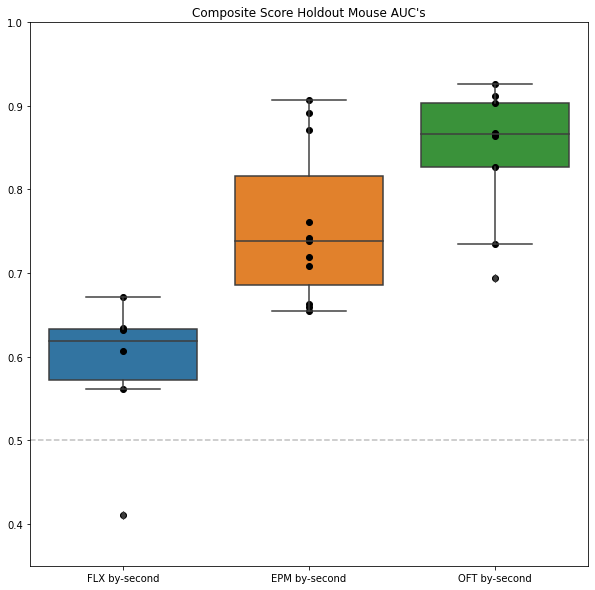

In [7]:
import seaborn as sns

plt.figure(figsize=(10,10))
sns.boxplot(data=[np.unique(flx_df["auc (last-30-minutes)"]),
                  np.unique(epm_df["auc (Homecage vs. Task)"]),
                  np.unique(oft_df["auc (Homecage vs. Task)"])]
           )

plt.scatter(np.zeros(np.unique(flx_df["auc (last-30-minutes)"]).shape),
            np.unique(flx_df["auc (last-30-minutes)"]),
           color="black")

plt.scatter(np.ones(np.unique(epm_df["auc (Homecage vs. Task)"]).shape),
            np.unique(epm_df["auc (Homecage vs. Task)"]),
           color="black")

plt.scatter(2*np.ones(np.unique(oft_df["auc (Homecage vs. Task)"]).shape),
            np.unique(oft_df["auc (Homecage vs. Task)"]),
           color="black")

plt.axhline(0.5,linestyle="dashed",color="gray",alpha=0.5)
plt.xticks([0,1,2],["FLX by-second","EPM by-second","OFT by-second"])
plt.title("Composite Score Holdout Mouse AUC's")
plt.ylim([.35,1])

#plt.savefig(FIGURE_PATH + "Composite Score Holdout AUCs Training Tasks.svg")
plt.show()

### Just OFT and EPM

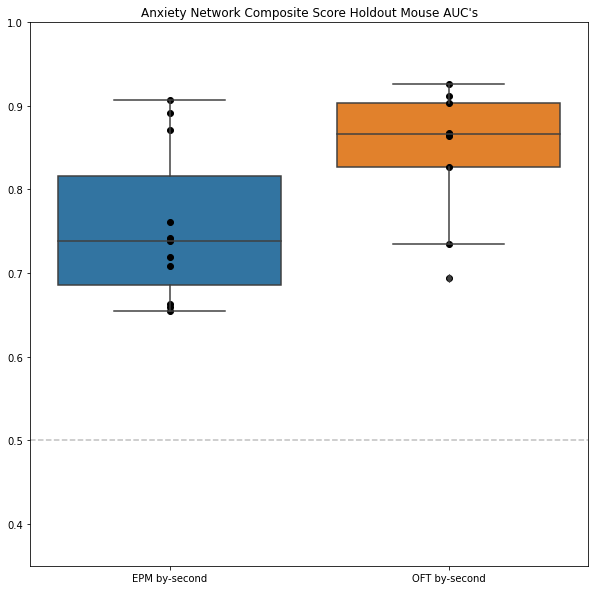

In [7]:
import seaborn as sns

plt.figure(figsize=(10,10))
sns.boxplot(data=[#np.unique(flx_df["auc (last-30-minutes)"]),
                  np.unique(epm_df["auc (Homecage vs. Task)"]),
                  np.unique(oft_df["auc (Homecage vs. Task)"])]
           )

#plt.scatter(np.zeros(np.unique(flx_df["auc (last-30-minutes)"]).shape),
#            np.unique(flx_df["auc (last-30-minutes)"]),
#           color="black")

plt.scatter(np.zeros(np.unique(epm_df["auc (Homecage vs. Task)"]).shape),
            np.unique(epm_df["auc (Homecage vs. Task)"]),
           color="black")

plt.scatter(np.ones(np.unique(oft_df["auc (Homecage vs. Task)"]).shape),
            np.unique(oft_df["auc (Homecage vs. Task)"]),
           color="black")

plt.axhline(0.5,linestyle="dashed",color="gray",alpha=0.5)
plt.xticks([0,1],["EPM by-second","OFT by-second"])
plt.title("Anxiety Network Composite Score Holdout Mouse AUC's")
plt.ylim([.35,1])

plt.savefig(FIGURE_PATH + "EPM and OFT Composite Score Holdout AUCs Training Tasks.svg")
plt.show()

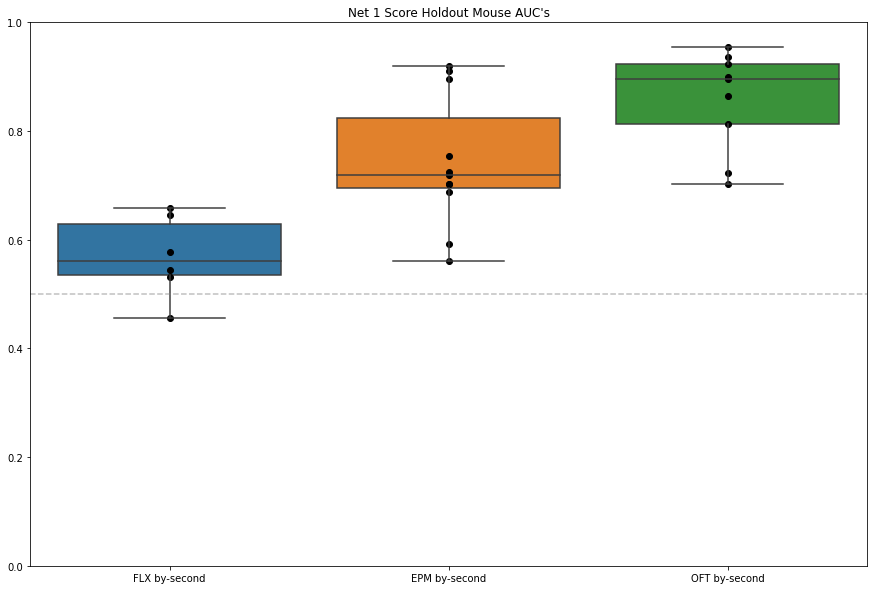

In [44]:
import seaborn as sns

plt.figure(figsize=(15,10))
sns.boxplot(data=[np.unique(flx_df["net 1 auc (last-30-minutes)"]),
                  np.unique(epm_df["net 1 auc (Homecage vs. Task)"]),
                  np.unique(oft_df["net 1 auc (Homecage vs. Task)"])]
           )

plt.scatter(np.zeros(np.unique(flx_df["net 1 auc (last-30-minutes)"]).shape),
            np.unique(flx_df["net 1 auc (last-30-minutes)"]),
           color="black")

plt.scatter(np.ones(np.unique(epm_df["net 1 auc (Homecage vs. Task)"]).shape),
            np.unique(epm_df["net 1 auc (Homecage vs. Task)"]),
           color="black")

plt.scatter(2*np.ones(np.unique(oft_df["net 1 auc (Homecage vs. Task)"]).shape),
            np.unique(oft_df["net 1 auc (Homecage vs. Task)"]),
           color="black")

plt.axhline(0.5,linestyle="dashed",color="gray",alpha=0.5)
plt.xticks([0,1,2],["FLX by-second","EPM by-second","OFT by-second"])
plt.title("Net 1 Score Holdout Mouse AUC's")
plt.ylim([0,1])

#plt.savefig(FIGURE_PATH + "Net 1 Score Holdout AUCs Training Tasks.svg")

plt.show()

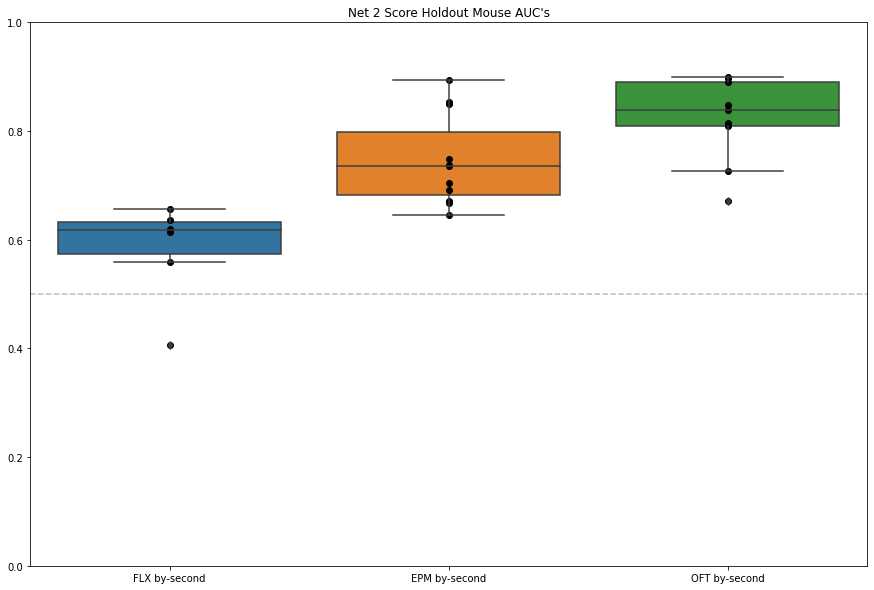

In [45]:
import seaborn as sns

plt.figure(figsize=(15,10))
sns.boxplot(data=[np.unique(flx_df["net 2 auc (last-30-minutes)"]),
                  np.unique(epm_df["net 2 auc (Homecage vs. Task)"]),
                  np.unique(oft_df["net 2 auc (Homecage vs. Task)"])]
           )

plt.scatter(np.zeros(np.unique(flx_df["net 2 auc (last-30-minutes)"]).shape),
            np.unique(flx_df["net 2 auc (last-30-minutes)"]),
           color="black")

plt.scatter(np.ones(np.unique(epm_df["net 2 auc (Homecage vs. Task)"]).shape),
            np.unique(epm_df["net 2 auc (Homecage vs. Task)"]),
           color="black")

plt.scatter(2*np.ones(np.unique(oft_df["net 2 auc (Homecage vs. Task)"]).shape),
            np.unique(oft_df["net 2 auc (Homecage vs. Task)"]),
           color="black")

plt.axhline(0.5,linestyle="dashed",color="gray",alpha=0.5)
plt.xticks([0,1,2],["FLX by-second","EPM by-second","OFT by-second"])
plt.title("Net 2 Score Holdout Mouse AUC's")
plt.ylim([0,1])

#plt.savefig(FIGURE_PATH + "Net 2 Score Holdout AUCs Training Tasks.svg")

plt.show()

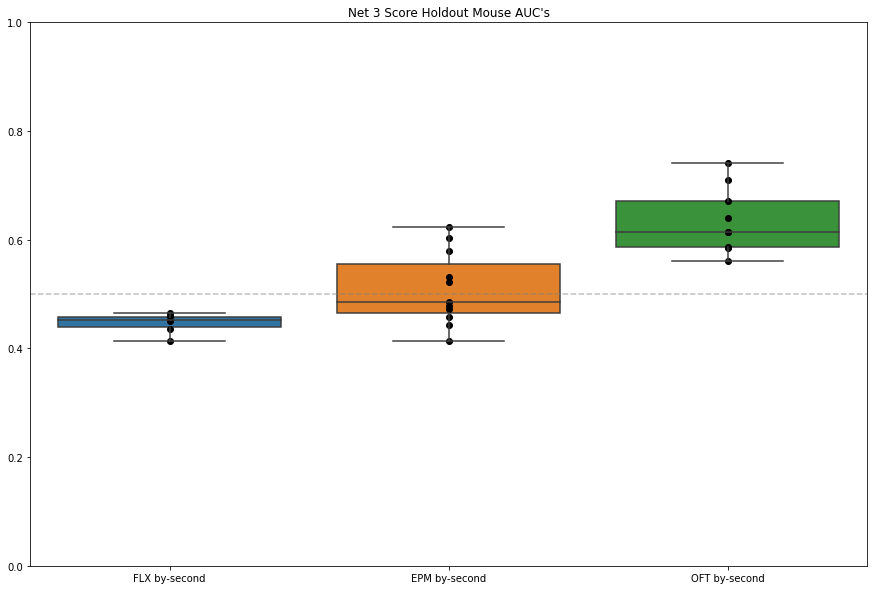

In [47]:
import seaborn as sns

plt.figure(figsize=(15,10))
sns.boxplot(data=[np.unique(flx_df["net 3 auc (last-30-minutes)"]),
                  np.unique(epm_df["net 3 auc (Homecage vs. Task)"]),
                  np.unique(oft_df["net 3 auc (Homecage vs. Task)"])]
           )

plt.scatter(np.zeros(np.unique(flx_df["net 3 auc (last-30-minutes)"]).shape),
            np.unique(flx_df["net 3 auc (last-30-minutes)"]),
           color="black")

plt.scatter(np.ones(np.unique(epm_df["net 3 auc (Homecage vs. Task)"]).shape),
            np.unique(epm_df["net 3 auc (Homecage vs. Task)"]),
           color="black")

plt.scatter(2*np.ones(np.unique(oft_df["net 3 auc (Homecage vs. Task)"]).shape),
            np.unique(oft_df["net 3 auc (Homecage vs. Task)"]),
           color="black")

plt.axhline(0.5,linestyle="dashed",color="gray",alpha=0.5)
plt.xticks([0,1,2],["FLX by-second","EPM by-second","OFT by-second"])
plt.title("Net 3 Score Holdout Mouse AUC's")
plt.ylim([0,1])
#plt.savefig(FIGURE_PATH + "Net 3 Score Holdout AUCs Training Tasks.svg")

plt.show()

In [1]:
model.auc_mw

NameError: name 'model' is not defined

In [4]:
epm_df.head()

,Unnamed: 0,net 1 scores,net 2 scores,net 3 scores,in-task,mouse,time,expDate,auc (Homecage vs. Task),net 1 auc (Homecage vs. Task),net 2 auc (Homecage vs. Task),net 3 auc (Homecage vs. Task),roi,velocity
0,0,0.081440,0.092658,0.096652,False,Mouse0641,1,110717,0.742232,0.71893,0.735664,0.442271,1,-2147483648
1,1,0.062944,0.062938,0.081924,False,Mouse0641,2,110717,0.742232,0.71893,0.735664,0.442271,1,-2147483648
2,2,0.083994,0.098514,0.112678,False,Mouse0641,4,110717,0.742232,0.71893,0.735664,0.442271,3,-2147483648
3,3,0.129436,0.163424,0.065320,False,Mouse0641,12,110717,0.742232,0.71893,0.735664,0.442271,3,-2147483648
4,4,0.072507,0.120995,0.040223,False,Mouse0641,13,110717,0.742232,0.71893,0.735664,0.442271,3,-2147483648


In [11]:
epm_roi = epm_df["roi"]%2==0
epm_mouse = epm_df.mouse
epm_in_task = epm_df["in-task"]

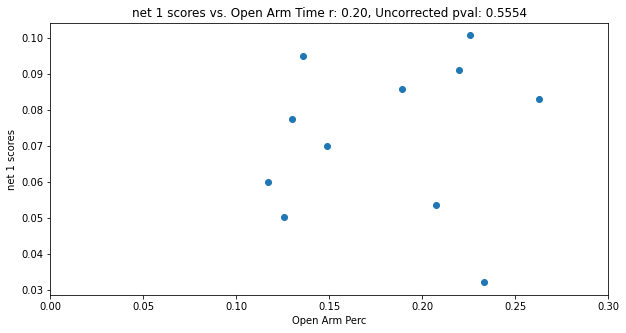

In [29]:
from scipy.stats import spearmanr

network_key = "net 1 scores"
open_arm_perc = []
avg_HC_scores = []
for mouse in np.unique(epm_mouse):
    task_mask = epm_in_task==1
    mouse_mask = epm_mouse==mouse
    task_mouse_mask = np.logical_and(task_mask,mouse_mask)
    
    perc_oa = np.sum(np.logical_and(task_mouse_mask,epm_roi==1)) / np.sum(task_mouse_mask)
    
    avg_hc_score = np.mean(epm_df[np.logical_and(1 - task_mask, mouse_mask)][network_key])
                           
    open_arm_perc.append(perc_oa)
    avg_HC_scores.append(avg_hc_score)
    
stat, pval = spearmanr(avg_HC_scores,open_arm_perc)

plt.figure(figsize=(10,5))
plt.scatter(open_arm_perc,avg_HC_scores)
plt.xlabel("Open Arm Perc")
plt.ylabel(network_key)
plt.title("{} vs. Open Arm Time r: {:.2f}, Uncorrected pval: {:.4f}".format(network_key,stat,pval))
plt.xlim([0,.3])

#plt.savefig(FIGURE_PATH + "CUS-EPM Avg Score vs OA Time-Perc Spearman.svg")
plt.show()

In [18]:
np.sum(np.logical_and(task_mouse_mask,epm_roi==1)) / np.sum(np.logical_and(task_mouse_mask))

TypeError: logical_and() takes from 2 to 3 positional arguments but 1 were given